# Modeling Notebook:

### This notebook includes the code for training, testing, and comparing our models. We use five different modeling approachs to find the best, compairing MSE and $R^2$.

### The models we experiment with include:
- DecisionTree
- ExtraTrees
- AdaBoost
- RandomForest
- GradientBoosting
- XGBoost

### We extract feature importance scores from each model to inform our index construction.

In [17]:
import pandas as pd
import numpy as np
import time
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
import shap
import pickle

from skopt import BayesSearchCV
from skopt.space import Categorical, Real, Integer
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn import metrics, linear_model
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, AdaBoostRegressor
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from xgboost import XGBRegressor
from scipy.stats import randint, uniform

import os
os.chdir('/sfs/qumulo/qhome/bdr6qz/Documents/MSDS/DS6050')
from print_imps import print_importances

import multiprocessing
# Get the number of CPU cores
n_jobs = multiprocessing.cpu_count()

In [18]:
# Load the data
df = pd.read_csv('df_clean.csv')
df_last = pd.read_csv('df_last.csv')
label_col_name = "mvp_share"
labels = df.pop(label_col_name)
stratify = df.pop("Rank")
df_selected = pd.read_csv('df_selected.csv')
feature_names = list(df_selected.columns)

In [19]:
feature_names

['VORP', 'PER', 'WS', 'MP', 'PTS', 'TS%', 'TOV', 'AST', 'Rk_Year', 'OWS']

In [20]:
# Split the data into training and testing sets
X_train_selected, X_test_selected, y_train, y_test = train_test_split(df_selected, 
                                                                      labels, 
                                                                      test_size=0.2, 
                                                                      stratify=stratify, 
                                                                      random_state=28)

# Convert to arrays
y_train = y_train.values
y_test = y_test.values
X_train = X_train_selected.values
X_test = X_test_selected.values

---

# DecisionTree

In [5]:
start_time = time.time()

# Define the hyperparameter search space for DecisionTreeRegressor
param_grid_Dtree = {
    'max_depth': Categorical([3, 10]),              # Max depth of the tree
    'min_samples_split': Integer(2, 20),            # Min no. of samples required to split an internal node
    'min_samples_leaf': Integer(1, 10),             # Min no. of samples required to be at a leaf node
    'max_features': Categorical(['log2', 'sqrt']),  # No. of features to consider at every split
}

# Initialize DecisionTreeRegressor
Dtree = DecisionTreeRegressor(random_state=28)

# Initialize BayesSearchCV
bayes_search_Dtree = BayesSearchCV(estimator=Dtree,
                                  search_spaces=param_grid_Dtree,
                                  n_iter=100,
                                  scoring='r2',
                                  cv=5,
                                  n_points=10,
                                  random_state=28,
                                  n_jobs=-1)

# Perform Bayesian Optimization
bayes_search_Dtree.fit(X_train, y_train)

# Get the best hyperparameters
best_params_Dtree = bayes_search_Dtree.best_params_
print("Best Hyperparameters:", best_params_Dtree)

# Get the best model
best_Dtree = bayes_search_Dtree.best_estimator_

# Make predictions on the test data using the best model
y_pred_Dtree = best_Dtree.predict(X_test)

# Evaluate the best model using mean squared error and R-squared
test_mse_Dtree = mean_squared_error(y_test, y_pred_Dtree)
test_r2_Dtree = r2_score(y_test, y_pred_Dtree)

print("Test MSE (Best DecisionTreeRegressor):", test_mse_Dtree)
print("Test R-squared (Best DecisionTreeRegressor):", test_r2_Dtree)

end_time = time.time()
execution_time = end_time - start_time

print(f"Model execution time: {round(execution_time/60, 2)} minutes")

The objective has been evaluated at point [10, 'sqrt', 6, 20] before, using random point [3, 'log2', 5, 11]
The objective has been evaluated at point [10, 'sqrt', 6, 2] before, using random point [10, 'log2', 7, 18]
The objective has been evaluated at point [10, 'log2', 8, 2] before, using random point [3, 'log2', 5, 10]
The objective has been evaluated at point [3, 'log2', 10, 20] before, using random point [10, 'sqrt', 8, 12]
The objective has been evaluated at point [3, 'log2', 10, 2] before, using random point [10, 'log2', 6, 8]
The objective has been evaluated at point [3, 'sqrt', 6, 20] before, using random point [3, 'sqrt', 6, 19]
The objective has been evaluated at point [3, 'sqrt', 6, 20] before, using random point [3, 'log2', 4, 10]
The objective has been evaluated at point [3, 'sqrt', 6, 20] before, using random point [10, 'sqrt', 2, 16]
The objective has been evaluated at point [10, 'sqrt', 9, 9] before, using random point [10, 'sqrt', 2, 7]
The objective has been evaluated

Best Hyperparameters: OrderedDict([('max_depth', 10), ('max_features', 'sqrt'), ('min_samples_leaf', 6), ('min_samples_split', 20)])
Test MSE (Best DecisionTreeRegressor): 0.002255869486008959
Test R-squared (Best DecisionTreeRegressor): 0.5579495285962077
Model execution time: 1.33 minutes


In [6]:
print_importances(feature_names, best_Dtree)

Feature Importances:
1: PER : 0.604
2: WS : 0.134
3: Rk_Year : 0.087
4: PTS : 0.063
5: VORP : 0.053
6: AST : 0.023
7: TOV : 0.017
8: MP : 0.014
9: TS% : 0.004
10: OWS : 0.002


---

# ExtraTreesRegressor

In [7]:
start_time = time.time()

# Define the hyperparameter grid
param_grid_Xtrees = {
    'n_estimators': Integer(100, 500),          # No. of trees in the forest
    'max_depth': Categorical([3, 10]),          # Max depth of each tree
    'min_samples_split': Integer(2, 20),        # Min no. of samples required to split an internal node
    'min_samples_leaf': Integer(1, 10),         # Min no. of samples required to be at a leaf node
    'max_features': Categorical([0.1, 1.0]),    # No. of features to consider when looking for the best split
    'bootstrap': Categorical([True, False])     # Whether to use bootstrap samples when building trees
}

# Initialize ExtraTreesRegressor
extra_trees_model = ExtraTreesRegressor(random_state=28)

# Initialize BayesSearchCV
bayes_search_Xtrees = BayesSearchCV(estimator=extra_trees_model,
                             search_spaces=param_grid_Xtrees,
                             n_iter=100,
                             scoring='r2',
                             cv=5,
                             n_points=10,
                             random_state=28,
                             n_jobs=n_jobs)

# Perform Bayesian Optimization
bayes_search_Xtrees.fit(X_train, y_train)

# Get the best hyperparameters
best_params = bayes_search_Xtrees.best_params_
print("Best Hyperparameters:", best_params)

# Get the best model
best_Xtrees = bayes_search_Xtrees.best_estimator_

# Make predictions on the test data using the best model
y_pred_Xtrees = best_Xtrees.predict(X_test)

# Evaluate the best model using mean squared error and R-squared
test_mse_Xtrees = mean_squared_error(y_test, y_pred_Xtrees)
test_r2_Xtrees = r2_score(y_test, y_pred_Xtrees)

print("Test MSE (Best ExtraTreesRegressor):", test_mse_Xtrees)
print("Test R-squared (Best ExtraTreesRegressor):", test_r2_Xtrees)

end_time = time.time()
execution_time = end_time - start_time

print(f"Model execution time: {round(execution_time/60, 2)} minutes")

The objective has been evaluated at point [False, 3, 1.0, 1, 2, 500] before, using random point [False, 10, 1.0, 3, 18, 228]
The objective has been evaluated at point [False, 3, 1.0, 4, 2, 500] before, using random point [False, 10, 1.0, 5, 12, 285]
The objective has been evaluated at point [False, 3, 1.0, 4, 2, 500] before, using random point [False, 10, 1.0, 4, 13, 159]
The objective has been evaluated at point [False, 3, 1.0, 4, 2, 500] before, using random point [False, 10, 0.1, 8, 7, 129]


Best Hyperparameters: OrderedDict([('bootstrap', True), ('max_depth', 10), ('max_features', 1.0), ('min_samples_leaf', 2), ('min_samples_split', 2), ('n_estimators', 407)])
Test MSE (Best ExtraTreesRegressor): 0.0011854994000993883
Test R-squared (Best ExtraTreesRegressor): 0.7676946419493497
Model execution time: 2.11 minutes


In [8]:
print_importances(feature_names, best_Xtrees)

Feature Importances:
1: WS : 0.238
2: VORP : 0.202
3: PER : 0.170
4: Rk_Year : 0.127
5: OWS : 0.114
6: PTS : 0.053
7: TOV : 0.031
8: AST : 0.025
9: MP : 0.021
10: TS% : 0.019


---

# AdaBoostRegressor

In [9]:
start_time = time.time()

# Define the hyperparameter grid
param_grid_Ada = {
    'n_estimators': Integer(50, 500),                         # No. of base estimators
    'learning_rate': Real(0.01, 1.0),                         # Learning rate to shrink each base estimator's contribution
    'loss': Categorical(['linear', 'square', 'exponential'])  # Loss function to update weights
}

# Initialize AdaBoostRegressor
adaboost_model = AdaBoostRegressor(random_state=28)

# Initialize BayesSearchCV
bayes_search_Ada = BayesSearchCV(estimator=adaboost_model,
                                 search_spaces=param_grid_Ada,
                                 n_iter=100,
                                 scoring='r2',
                                 cv=5,
                                 n_points=10,
                                 random_state=28,
                                 n_jobs=n_jobs)

# Perform Bayesian Optimization
bayes_search_Ada.fit(X_train, y_train)

# Get the best hyperparameters
best_params = bayes_search_Ada.best_params_
print("Best Hyperparameters:", best_params)

# Get the best model
best_Ada = bayes_search_Ada.best_estimator_

# Make predictions on the test data using the best model
y_pred_Ada = best_Ada.predict(X_test)

# Evaluate the best model using mean squared error and R-squared
test_mse_Ada = mean_squared_error(y_test, y_pred_Ada)
test_r2_Ada = r2_score(y_test, y_pred_Ada)

print("Test MSE (Best AdaBoostRegressor):", test_mse_Ada)
print("Test R-squared (Best AdaBoostRegressor):", test_r2_Ada)

end_time = time.time()
execution_time = end_time - start_time

print(f"Model execution time: {round(execution_time/60, 2)} minutes")

Best Hyperparameters: OrderedDict([('learning_rate', 0.01), ('loss', 'linear'), ('n_estimators', 124)])
Test MSE (Best AdaBoostRegressor): 0.0013750943318778482
Test R-squared (Best AdaBoostRegressor): 0.7305424354550307
Model execution time: 2.61 minutes


In [10]:
print_importances(feature_names, best_Ada)

Feature Importances:
1: PER : 0.393
2: WS : 0.260
3: VORP : 0.130
4: Rk_Year : 0.127
5: TOV : 0.027
6: PTS : 0.022
7: AST : 0.018
8: MP : 0.012
9: TS% : 0.007
10: OWS : 0.004


---

# Random Forest

In [11]:
start_time = time.time()

# Define the hyperparameter grid
param_grid_rf = {
    'n_estimators': Integer(200, 300),              # No. of trees in the forest
    'max_features': Categorical(['log2', 'sqrt']),  # No. of features to consider at every split
    'max_depth': Categorical([None, 10, 20]),       # Max depth of the trees
    'min_samples_split': Integer(2, 5),             # Min no. of samples required to split an internal node
    'min_samples_leaf': Integer(1, 5),              # Min no. of samples required to be at a leaf node
    'bootstrap': Categorical([True, False])         # Method to select samples for training each tree
}

# Initialize XGBRegressor
rf = RandomForestRegressor(random_state=28)

# Initialize BayesSearchCV
bayes_rf = BayesSearchCV(estimator=rf, 
                         search_spaces=param_grid_rf,
                         n_iter=100, 
                         scoring='r2', 
                         cv=5, 
                         random_state=28,
                         n_points=10,
                         n_jobs=n_jobs)

# Perform Bayesian Optimization
bayes_rf.fit(X_train, y_train)

# Get the best hyperparameters
best_params_rf = bayes_rf.best_params_
print("Best Hyperparameters (Random Forest):", best_params_rf)

# Get the best model
best_rf = bayes_rf.best_estimator_

# Make predictions on the test data using the best model
y_pred_rf = best_rf.predict(X_test)

# Evaluate the best model using mean squared error and R-squared
test_mse_rf = mean_squared_error(y_test, y_pred_rf)
test_r2_rf = r2_score(y_test, y_pred_rf)

print("Test MSE (Best Random Forest):", test_mse_rf)
print("Test R-squared (Best Random Forest):", test_r2_rf)

end_time = time.time()
execution_time = end_time - start_time
print(f"Model execution time: {round(execution_time/60, 2)} minutes")

Best Hyperparameters (Random Forest): OrderedDict([('bootstrap', True), ('max_depth', 20), ('max_features', 'log2'), ('min_samples_leaf', 1), ('min_samples_split', 3), ('n_estimators', 202)])
Test MSE (Best Random Forest): 0.0013197524868298262
Test R-squared (Best Random Forest): 0.7413869851258164
Model execution time: 3.3 minutes


In [12]:
print_importances(feature_names, best_rf)

Feature Importances:
1: WS : 0.220
2: PER : 0.190
3: VORP : 0.173
4: Rk_Year : 0.102
5: OWS : 0.095
6: PTS : 0.078
7: TOV : 0.038
8: AST : 0.037
9: MP : 0.035
10: TS% : 0.032


---

# Gradient Boosting Regressor

In [ ]:
start_time = time.time()

# Define the parameter grid for GradientBoostingRegressor
param_grid_gb = {
    'n_estimators': Integer(100, 300),                  # No. of boosting stages
    'learning_rate': Real(0.05, 0.1, prior='uniform'),  # Learning rate
    'max_depth': Categorical([3, 5]),                   # Max depth of the individual trees
    'min_samples_split': Integer(2, 5),                 # Min no. of samples required to split an internal node
    'min_samples_leaf': Integer(1, 2),                  # Min no. of samples required to be at a leaf node
    'subsample': Real(0.6, 0.8, prior='uniform'),       # Fraction of samples used to fit individual base learners
    'max_features': Categorical(['log2', 'sqrt'])       # No. of features to consider when looking for the best split
}

# Initialize GradientBoostingRegressor
gb_model = GradientBoostingRegressor(random_state=28)

# Initialize BayesSearchCV
bayes_search_gb = BayesSearchCV(estimator=gb_model, 
                                search_spaces=param_grid_gb,
                                n_iter=100, 
                                scoring='r2', 
                                cv=5,
                                n_points=10,
                                n_jobs=n_jobs,
                                random_state=28)

# Perform random search
bayes_search_gb.fit(X_train, y_train)

# Get the best hyperparameters
best_params_gb = bayes_search_gb.best_params_
print("Best Hyperparameters (Gradient Boosting):", best_params_gb)

# Get the best model
best_gb = bayes_search_gb.best_estimator_

# Make predictions on the test data using the best model
y_pred_gb = best_gb.predict(X_test)

# Evaluate the best model using mean squared error and R-squared
test_mse_gb = mean_squared_error(y_test, y_pred_gb)
test_r2_gb = r2_score(y_test, y_pred_gb)

print("Test MSE:", test_mse_gb)
print("Test R-squared:", test_r2_gb)

end_time = time.time()
execution_time = end_time - start_time
print(f"Model execution time: {round(execution_time/60, 2)} minutes")

In [ ]:
print_importances(feature_names, best_gb)

---

## XGBoost Regressor

In [ ]:
start_time = time.time()

# Define the hyperparameter search space
param_grid_XGB = {
    'n_estimators': Integer(100, 500),                    # No. of trees in the forest
    'learning_rate': Real(0.01, 0.3, prior='uniform'),    # Learning rate
    'max_depth': Categorical([3, 10]),                    # Max depth of each tree
    'min_child_weight': Integer(1, 10),                   # Min sum of instance weight needed in a child
    'subsample': Real(0.6, 1.0, prior='uniform'),         # Subsample ratio of the training instance
    'colsample_bytree': Real(0.6, 1.0, prior='uniform'),  # Subsample ratio of columns when constructing each tree
    'gamma': Real(0, 0.5, prior='uniform'),               # Min loss reduction to further partition on a leaf node
    'reg_alpha': Real(0, 1.0, prior='uniform'),           # L1 reg term on weights
    'reg_lambda': Real(0, 1.0, prior='uniform')           # L2 reg term on weights
}

# Initialize XGBRegressor
xgb_model = XGBRegressor(random_state=28)

# Initialize BayesSearchCV
bayes_search = BayesSearchCV(estimator=xgb_model, 
                             search_spaces=param_grid_XGB,
                             n_iter=100, 
                             scoring='r2', 
                             cv=5,
                             n_points=10,
                             random_state=28, 
                             n_jobs=n_jobs)

# Perform Bayesian Optimization
bayes_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = bayes_search.best_params_
print("Best Hyperparameters:", best_params)

# Get the best model
best_xgb = bayes_search.best_estimator_

# Make predictions on the test data using the best model
y_pred_xgb = best_xgb.predict(X_test)

# Evaluate the best model using mean squared error and R-squared
test_mse_xgb = mean_squared_error(y_test, y_pred_xgb)
test_r2_xgb = r2_score(y_test, y_pred_xgb)

print("Test MSE (Best XGBoost):", test_mse_xgb)
print("Test R-squared (Best XGBoost):", test_r2_xgb)

end_time = time.time()
execution_time = end_time - start_time

print(f"Model execution time: {round(execution_time/60, 2)} minutes")

In [ ]:
print_importances(feature_names, best_xgb)

---

# Model Comparisons

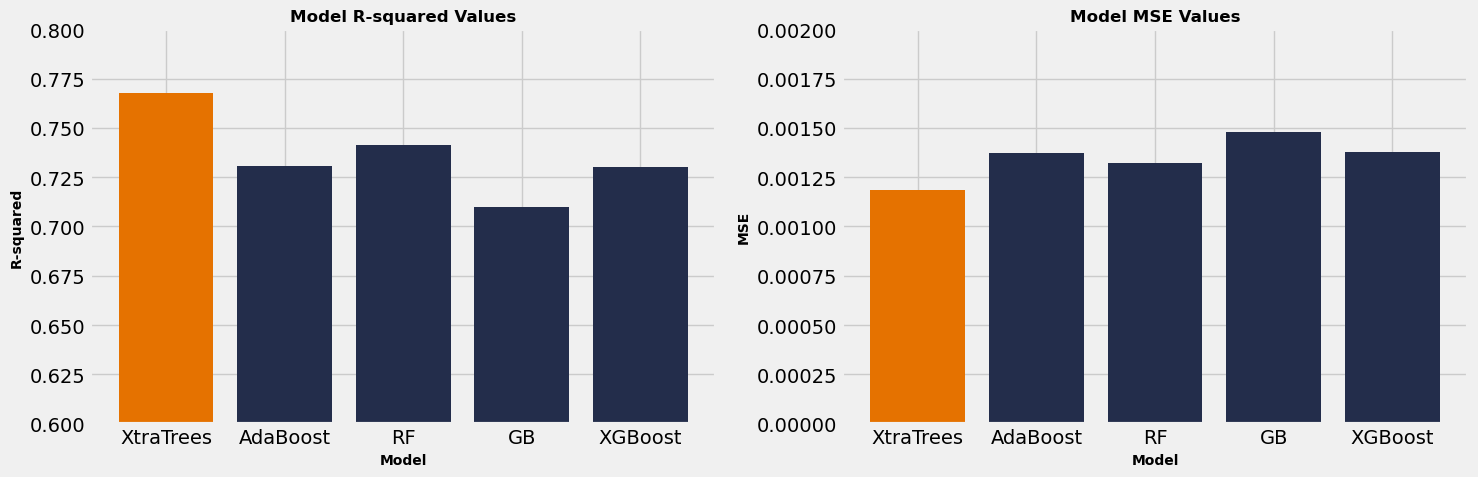

In [21]:
# Data for R-squared values
r_sqs = [test_r2_Xtrees, test_r2_Ada, test_r2_rf, test_r2_gb, test_r2_xgb]

# Data for MSE values
MSE_s = [test_mse_Xtrees, test_mse_Ada, test_mse_rf, test_mse_gb, test_mse_xgb]

# List of model names
model_names = ['XtraTrees', 'AdaBoost', 'RF', 'GB', 'XGBoost']

# Determine colors for R-squared bars
r_sq_colors = ['#E57200' if r == max(r_sqs) else '#232D4B' for r in r_sqs]

# Determine colors for MSE bars
mse_colors = ['#E57200' if mse == min(MSE_s) else '#232D4B' for mse in MSE_s]

plt.style.use('fivethirtyeight')

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Plot the R-squared values
axs[0].bar(model_names, r_sqs, color=r_sq_colors)
axs[0].set_xlabel('Model', fontdict={'fontsize': 10, 'fontweight': 'bold'})
axs[0].set_ylabel('R-squared', fontdict={'fontsize': 10, 'fontweight': 'bold'})
axs[0].set_title('Model R-squared Values', fontdict={'fontsize': 12, 'fontweight': 'bold'})
axs[0].tick_params(axis='x', rotation=0)
axs[0].set_ylim(0.6, 0.8)

# Plot the MSE values
axs[1].bar(model_names, MSE_s, color=mse_colors)
axs[1].set_xlabel('Model', fontdict={'fontsize': 10, 'fontweight': 'bold'})
axs[1].set_ylabel('MSE', fontdict={'fontsize': 10, 'fontweight': 'bold'})
axs[1].set_title('Model MSE Values', fontdict={'fontsize': 12, 'fontweight': 'bold'})
axs[1].tick_params(axis='x', rotation=0)
axs[1].set_ylim(0, 0.002)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

In [22]:
# Save the best model
joblib.dump(best_Xtrees, 'best_Xtrees.pkl')

['best_Xtrees.pkl']